In [3]:
pip install xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# %% [markdown]
# # Model Training for Airfare Prediction

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# %%
# Load processed data
df = pd.read_pickle('../data/processed/processed_data.pkl')

# Load preprocessor
preprocessor = joblib.load('../models/preprocessor.pkl')

# %%
# Prepare data
X = df.drop('price', axis=1)
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Transform data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)



In [6]:
# %% [markdown]
# ## Model Training

# %%
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# %%
# Train and evaluate models
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_processed, y_train, 
                               cv=5, scoring='r2')
    
    # Store results
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV R2 Mean': cv_scores.mean(),
        'CV R2 Std': cv_scores.std()
    })
    
    # Save model
    joblib.dump(model, f'../models/{name.lower().replace(" ", "_")}.pkl')
    
    print(f"{name} trained and saved.")

# %%
# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance:")
display(results_df)

# Save results
results_df.to_csv('../models/model_performance.csv', index=False)




Training Linear Regression...
Linear Regression trained and saved.

Training Random Forest...
Random Forest trained and saved.

Training XGBoost...
XGBoost trained and saved.

Model Performance:


,Model,MSE,RMSE,R2,CV R2 Mean,CV R2 Std
0,Linear Regression,4.572062e+07,6761.702368,0.911305,0.911469,0.000828
1,Random Forest,1.925701e+07,4388.280712,0.962643,0.963589,0.000506
2,XGBoost,1.384836e+07,3721.338211,0.973135,0.973555,0.000540


In [7]:
# %% [markdown]
# ## Model Selection

# %%
# Identify best model
best_model_idx = results_df['R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name} with R2: {results_df.loc[best_model_idx, 'R2']:.4f}")

# Save best model
joblib.dump(best_model, '../models/best_model.pkl')




Best model: XGBoost with R2: 0.9731


['../models/best_model.pkl']

In [8]:
# %% [markdown]
# ## Feature Importance Analysis

# %%
# Get feature names
feature_names = pd.read_csv('../models/feature_names.csv')[0].values

# Plot feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    
    # Create DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', 
                data=feature_importance.head(20))
    plt.title(f'Top 20 Important Features - {best_model_name}')
    plt.tight_layout()
    plt.savefig('../reports/figures/final_feature_importance.png')
    plt.show()



KeyError: 0

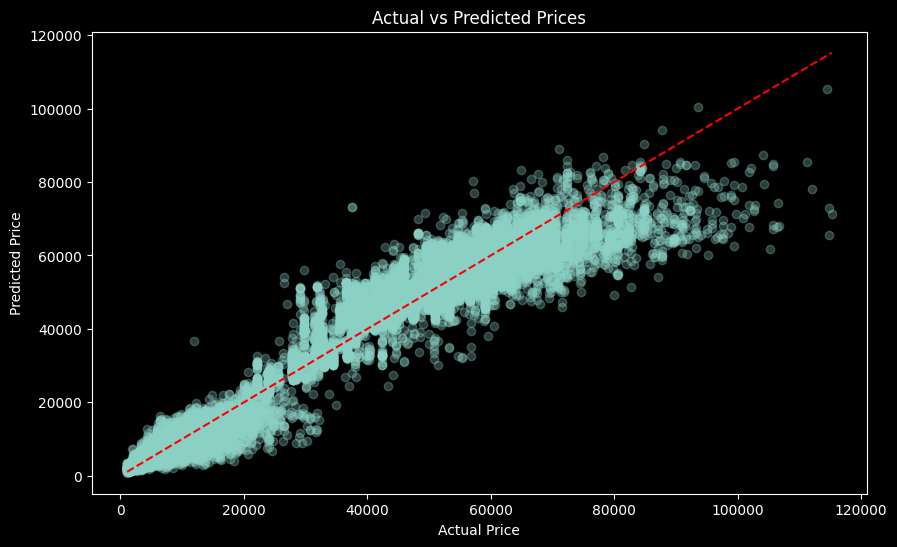

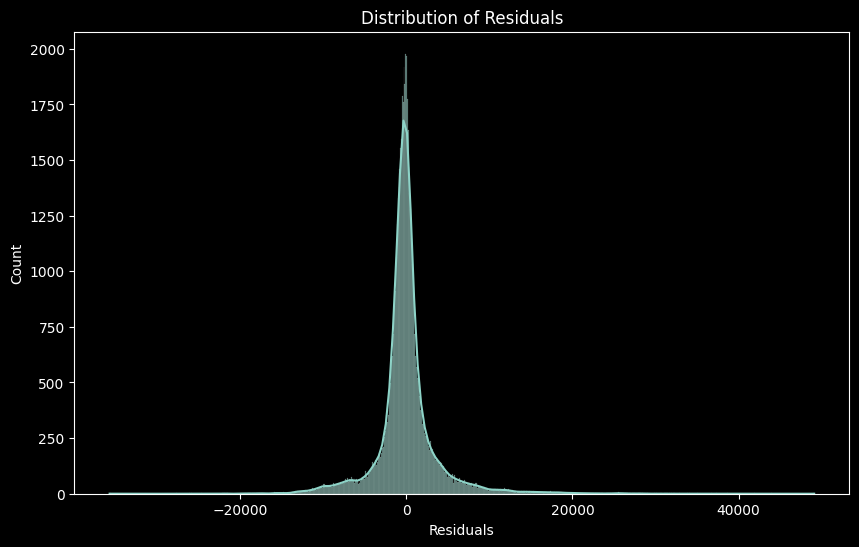

In [9]:
# %% [markdown]
# ## Prediction Analysis

# %%
# Analyze predictions vs actual
y_pred_best = best_model.predict(X_test_processed)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.savefig('../reports/figures/actual_vs_predicted.png')
plt.show()

# %%
# Residual analysis
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.savefig('../reports/figures/residuals_distribution.png')
plt.show()